# Neural Nets with Keras

In this notebook you will learn how to implement neural networks using the Keras API. We will use TensorFlow's own implementation, *tf.keras*, which comes bundled with TensorFlow.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/tf2_course/blob/master/01_neural_nets_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

Don't hesitate to look at the documentation at [keras.io](https://keras.io/). All the code examples should work fine with tf.keras, the only difference is how to import Keras:

```python
# keras.io code:
from keras.layers import Dense
output_layer = Dense(10)

# corresponding tf.keras code:
from tensorflow.keras.layers import Dense
output_layer = Dense(10)

# or:
from tensorflow import keras
output_layer = keras.layers.Dense(10)
```

In this notebook, we will not use any TensorFlow-specific code, so everything you see would run just the same way on [keras-team](https://github.com/keras-team/keras) or any other Python implementation of the Keras API (except for the imports).

## Imports

In [1]:
%matplotlib inline
%load_ext tensorboard

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time

2023-05-13 13:58:32.147128: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.9.0
keras.api._v2.keras 2.9.0


In [4]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 1 – TensorFlow Playground

Visit the [TensorFlow Playground](http://playground.tensorflow.org).
* **Layers and patterns**: try training the default neural network by clicking the "Run" button (top left). Notice how it quickly finds a good solution for the classification task. Notice that the neurons in the first hidden layer have learned simple patterns, while the neurons in the second hidden layer have learned to combine the simple patterns of the first hidden layer into more complex patterns). In general, the more layers, the more complex the patterns can be.
* **Activation function**: try replacing the Tanh activation function with the ReLU activation function, and train the network again. Notice that it finds a solution even faster, but this time the boundaries are linear. This is due to the shape of the ReLU function.
* **Local minima**: modify the network architecture to have just one hidden layer with three neurons. Train it multiple times (to reset the network weights, just add and remove a neuron). Notice that the training time varies a lot, and sometimes it even gets stuck in a local minimum.
* **Too small**: now remove one neuron to keep just 2. Notice that the neural network is now incapable of finding a good solution, even if you try multiple times. The model has too few parameters and it systematically underfits the training set.
* **Large enough**: next, set the number of neurons to 8 and train the network several times. Notice that it is now consistently fast and never gets stuck. This highlights an important finding in neural network theory: large neural networks almost never get stuck in local minima, and even when they do these local optima are almost as good as the global optimum. However, they can still get stuck on long plateaus for a long time.
* **Deep net and vanishing gradients**: now change the dataset to be the spiral (bottom right dataset under "DATA"). Change the network architecture to have 4 hidden layers with 8 neurons each. Notice that training takes much longer, and often gets stuck on plateaus for long periods of time. Also notice that the neurons in the highest layers (i.e. on the right) tend to evolve faster than the neurons in the lowest layers (i.e. on the left). This problem, called the "vanishing gradients" problem, can be alleviated using better weight initialization and other techniques, better optimizers (such as AdaGrad or Adam), or using Batch Normalization.
* **More**: go ahead and play with the other parameters to get a feel of what they do. In fact, after this course you should definitely play with this UI for at least one hour, it will grow your intuitions about neural networks significantly.

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 2 – Image classification with tf.keras

### Load the Fashion MNIST dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (
    fashion_mnist.load_data())
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

The training set contains 55,000 grayscale images, each 28x28 pixels:

In [6]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented by a uint8 (byte) from 0 to 255:

In [7]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  44, 127,
        182, 185, 161, 120,  55,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 198, 251, 255,
        251, 249, 247, 255, 252, 214, 100,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   2,   0,   0, 233, 252, 237, 239,
        234, 237, 235, 237, 237, 254, 227,   0,   0,   0,   0,   1,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   2,   0,   0,  16, 210, 225, 215, 175,
        217, 216, 193, 196, 226, 221, 209,  50,   0,   0,   2,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   2,   0,   0, 199, 229, 232, 230, 245, 204,
        219, 253, 245, 207, 194, 223, 231, 236, 235,   0,   0,   3,   0,
          0,   0],
       [  

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

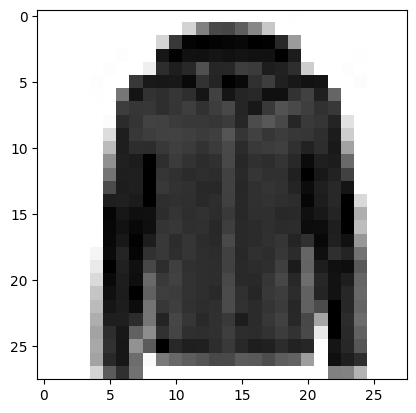

In [8]:
plt.imshow(X_train[0], cmap="binary")
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [9]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [10]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [11]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [12]:
X_valid.shape

(5000, 28, 28)

In [13]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

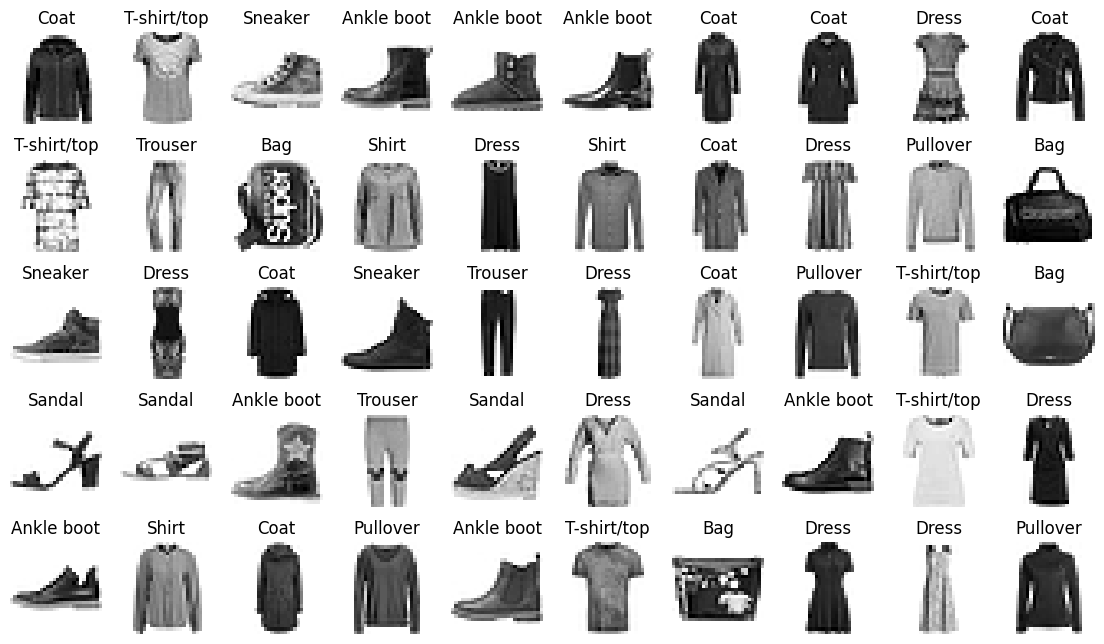

In [14]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

This dataset has the same structure as the famous MNIST dataset (which you can load using `keras.datasets.mnist.load_data()`), except the images represent fashion items rather than handwritten digits, and it is much more challenging. A simple linear model can reach 92% accuracy on MNIST, but only 83% on fashion MNIST.

### Build a classification neural network with Keras

### 2.1)
Build a `Sequential` model (`keras.models.Sequential`), without any argument, then and add four layers to it by calling its `add()` method:
  * a `Flatten` layer (`keras.layers.Flatten`) to convert each 28x28 image to a single row of 784 pixel values. Since it is the first layer in your model, you should specify the `input_shape` argument, leaving out the batch size: `[28, 28]`.
  * a `Dense` layer  (`keras.layers.Dense`) with 300 neurons (aka units), and the `"relu"` activation function.
  * Another `Dense` layer with 100 neurons, also with the `"relu"` activation function.
  * A final `Dense` layer with 10 neurons (one per class), and with the `"softmax"` activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [15]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation="relu"))

2023-05-13 13:58:52.699599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 13:58:57.070822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20661 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9
2023-05-13 13:58:57.074657: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20661 MB memory:  -> device: 1, name: NVIDIA L4, pci bus id: 0000:00:04.0, compute capability: 8.9
2023-05-13 13:58:57.078447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:G

### 2.2)
Alternatively, you can pass a list containing the 4 layers to the constructor of the `Sequential` model. The model's `layers` attribute holds the list of layers.

### 2.3)
Call the model's `summary()` method and examine the output. Also, try using `keras.utils.plot_model()` to save an image of your model's architecture. Alternatively, you can uncomment the following code to display the image within Jupyter.

**Warning**: you will need `pydot` and `graphviz` to use `plot_model()`.

### 2.4)
After a model is created, you must call its `compile()` method to specify the `loss` function and the `optimizer` to use. In this case, you want to use the `"sparse_categorical_crossentropy"` loss, and the `keras.optimizers.SGD(lr=1e-3)` optimizer (stochastic gradient descent with a learning rate of 1e-3). Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case you should specify `metrics=["accuracy"]`. **Note**: you can find more loss functions in `keras.losses`, more metrics in `keras.metrics` and more optimizers in `keras.optimizers`.

### 2.5)
Now your model is ready to be trained. Call its `fit()` method, passing it the input features (`X_train`) and the target classes (`y_train`). Set `epochs=10` (or else it will just run for a single epoch). You can also (optionally) pass the validation data by setting `validation_data=(X_valid, y_valid)`. If you do, Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a mismatch between the training set and the validation set).
**Note**: the `fit()` method will return a `History` object containing training stats. Make sure to preserve it (`history = model.fit(...)`).

### 2.6)
Try running `pd.DataFrame(history.history).plot()` to plot the learning curves. To make the graph more readable, you can also set `figsize=(8, 5)`, call `plt.grid(True)` and `plt.gca().set_ylim(0, 1)`.

### 2.7)
Try running `model.fit()` again, and notice that training continues where it left off.

### 2.8)
call the model's `evaluate()` method, passing it the test set (`X_test` and `y_test`). This will compute the loss (cross-entropy) on the test set, as well as all the additional metrics (in this case, the accuracy). Your model should achieve over 80% accuracy on the test set.

### 2.9)
Define `X_new` as the first 10 instances of the test set. Call the model's `predict()` method to estimate the probability of each class for each instance (for better readability, you may use the output array's `round()` method):

### 2.10)
Often, you may only be interested in the most likely class. Use `np.argmax()` to get the class ID of the most likely class for each instance. **Tip**: you want to set `axis=1`.

### 2.11)
(Optional) It is often useful to know how confident the model is for each prediction. Try finding the estimated probability for each predicted class using `np.max()`.

### 2.12)
(Optional) It is frequent to want the top k classes and their estimated probabilities rather just the most likely class. You can use `np.argsort()` for this.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 2 - Solution

### 2.1)
Build a `Sequential` model (`keras.models.Sequential`), without any argument, then and add four layers to it by calling its `add()` method:
  * a `Flatten` layer (`keras.layers.Flatten`) to convert each 28x28 image to a single row of 784 pixel values. Since it is the first layer in your model, you should specify the `input_shape` argument, leaving out the batch size: `[28, 28]`.
  * a `Dense` layer  (`keras.layers.Dense`) with 300 neurons (aka units), and the `"relu"` activation function.
  * Another `Dense` layer with 100 neurons, also with the `"relu"` activation function.
  * A final `Dense` layer with 10 neurons (one per class), and with the `"softmax"` activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [16]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

### 2.2)
Alternatively, you can pass a list containing the 4 layers to the constructor of the `Sequential` model. The model's `layers` attribute holds the list of layers.

In [17]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.layers

### 2.3)
Call the model's `summary()` method and examine the output. Also, try using `keras.utils.plot_model()` to save an image of your model's architecture. Alternatively, you can uncomment the following code to display the image within Jupyter.

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 300)               235500    
                                                                 
 dense_5 (Dense)             (None, 100)               30100     
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


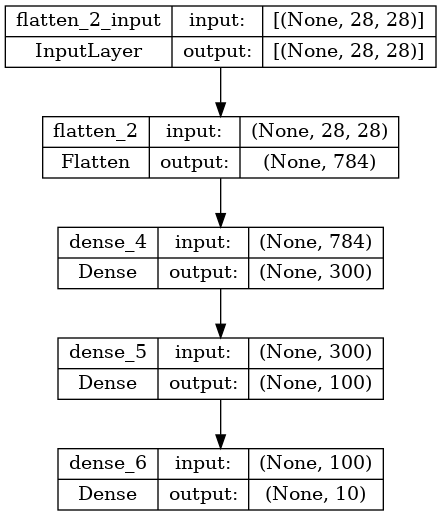

In [20]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

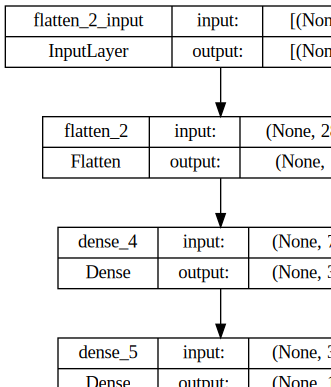

In [21]:
from IPython.display import SVG
SVG(keras.utils.model_to_dot(model, show_shapes=True).create(prog="dot", format="svg"))

### 2.4)
After a model is created, you must call its `compile()` method to specify the `loss` function and the `optimizer` to use. In this case, you want to use the `"sparse_categorical_crossentropy"` loss, and the `keras.optimizers.SGD(lr=1e-3)` optimizer (stochastic gradient descent with learning rate of 1e-3). Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case you should specify `metrics=["accuracy"]`. **Note**: you can find more loss functions in `keras.losses`, more metrics in `keras.metrics` and more optimizers in `keras.optimizers`.

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### 2.5)
Now your model is ready to be trained. Call its `fit()` method, passing it the input features (`X_train`) and the target classes (`y_train`). Set `epochs=10` (or else it will just run for a single epoch). You can also (optionally) pass the validation data by setting `validation_data=(X_valid, y_valid)`. If you do, Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a mismatch between the training set and the validation set).
**Note**: the `fit()` method will return a `History` object containing training stats. Make sure to preserve it (`history = model.fit(...)`).

In [23]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
  50/1719 [..............................] - ETA: 3s - loss: 62.6118 - accuracy: 0.4038  

2023-05-13 13:59:07.982765: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1719/1719 [==============================] - 5s 2ms/step - loss: 2.6071 - accuracy: 0.6902 - val_loss: 0.6481 - val_accuracy: 0.7608
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6029 - accuracy: 0.7742 - val_loss: 0.5589 - val_accuracy: 0.8082
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5212 - accuracy: 0.8119 - val_loss: 0.5300 - val_accuracy: 0.8108
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4787 - accuracy: 0.8257 - val_loss: 0.4756 - val_accuracy: 0.8322
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4482 - accuracy: 0.8348 - val_loss: 0.4717 - val_accuracy: 0.8348
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4265 - accuracy: 0.8423 - val_loss: 0.4513 - val_accuracy: 0.8368
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4102 - accuracy: 0.8467 - val_loss: 0.4546 - val_accuracy: 0.8414
Epo

### 2.6)
Try running `pd.DataFrame(history.history).plot()` to plot the learning curves. To make the graph more readable, you can also set `figsize=(8, 5)`, call `plt.grid(True)` and `plt.gca().set_ylim(0, 1)`.

In [24]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

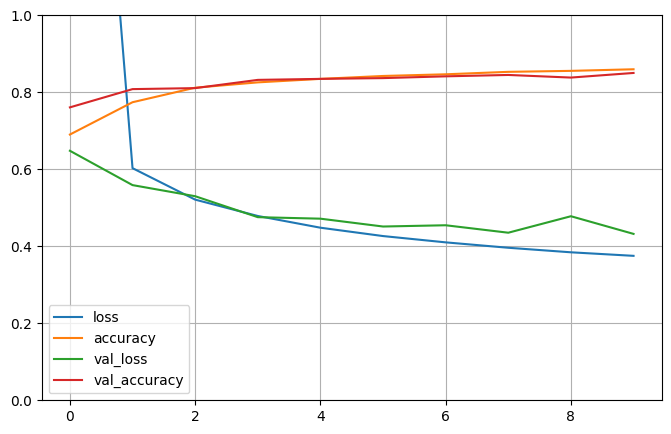

In [25]:
plot_learning_curves(history)

### 2.7)
Try running `model.fit()` again, and notice that training continues where it left off.

In [26]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3655 - accuracy: 0.8643 - val_loss: 0.4333 - val_accuracy: 0.8458
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3581 - accuracy: 0.8651 - val_loss: 0.4197 - val_accuracy: 0.8524
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3501 - accuracy: 0.8673 - val_loss: 0.4143 - val_accuracy: 0.8572
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3442 - accuracy: 0.8705 - val_loss: 0.4296 - val_accuracy: 0.8498
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3368 - accuracy: 0.8730 - val_loss: 0.4120 - val_accuracy: 0.8568
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3313 - accuracy: 0.8753 - val_loss: 0.4272 - val_accuracy: 0.8504
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3261 - accuracy: 0.8769 - val_loss: 0.4123 - val_accuracy:

### 2.8)
Call the model's `evaluate()` method, passing it the test set (`X_test` and `y_test`). This will compute the loss (cross-entropy) on the test set, as well as all the additional metrics (in this case, the accuracy). Your model should achieve over 80% accuracy on the test set.

In [27]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4505 - accuracy: 0.8440


[0.4505234360694885, 0.843999981880188]

### 2.9)
Define `X_new` as the first 10 instances of the test set. Call the model's `predict()` method to estimate the probability of each class for each instance (for better readability, you may use the output array's `round()` method):

In [28]:
n_new = 10
X_new = X_test[:n_new]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 179ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.33, 0.  , 0.13, 0.03, 0.01, 0.  , 0.5 , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.07, 0.  , 0.92, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.95, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ]],
      dtype=float32)

### 2.10)
Often, you may only be interested in the most likely class. Use `np.argmax()` to get the class ID of the most likely class for each instance. **Tip**: you want to set `axis=1`.

In [29]:
y_pred = y_proba.argmax(axis=1)
y_pred

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

### 2.11)
(Optional) It is often useful to know how confident the model is for each prediction. Try finding the estimated probability for each predicted class using `np.max()`.

In [30]:
y_proba.max(axis=1).round(2)

array([1.  , 0.99, 1.  , 1.  , 0.5 , 1.  , 0.92, 0.95, 1.  , 1.  ],
      dtype=float32)

### 2.12)
(Optional) It is frequent to want the top k classes and their estimated probabilities rather just the most likely class. You can use `np.argsort()` for this.

In [31]:
k = 3
top_k = np.argsort(-y_proba, axis=1)[:, :k]
top_k

array([[9, 5, 7],
       [2, 6, 4],
       [1, 0, 6],
       [1, 0, 9],
       [6, 0, 2],
       [1, 0, 6],
       [4, 2, 6],
       [6, 4, 2],
       [5, 2, 3],
       [7, 5, 9]])

In [32]:
row_indices = np.tile(np.arange(len(top_k)), [k, 1]).T
y_proba[row_indices, top_k].round(2)

array([[1.  , 0.  , 0.  ],
       [0.99, 0.01, 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.5 , 0.33, 0.13],
       [1.  , 0.  , 0.  ],
       [0.92, 0.07, 0.  ],
       [0.95, 0.04, 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ]], dtype=float32)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 3 – Scale the features

### 3.1)
When using Gradient Descent, it is usually best to ensure that the features all have a similar scale, preferably with a Normal distribution. Try to standardize the pixel values and see if this improves the performance of your neural network.

**Tips**:
* For each feature (pixel intensity), you must subtract the `mean()` of that feature (across all instances, so use `axis=0`) and divide by its standard deviation (`std()`, again `axis=0`). Alternatively, you can use Scikit-Learn's `StandardScaler`.
* Make sure you compute the means and standard deviations on the training set, and use these statistics to scale the training set, the validation set and the test set (you should not fit the validation set or the test set, and computing the means and standard deviations counts as "fitting").

### 3.2)
Plot the learning curves. Do they look better than earlier?

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 3 – Solution

### 3.1)
When using Gradient Descent, it is usually best to ensure that the features all have a similar scale, preferably with a Normal distribution. Try to standardize the pixel values and see if this improves the performance of your neural network.

In [33]:
pixel_means = X_train.mean(axis = 0)
pixel_stds = X_train.std(axis = 0)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

In [35]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(1e-3), metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.9404 - accuracy: 0.7025 - val_loss: 0.6214 - val_accuracy: 0.7912
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5790 - accuracy: 0.8004 - val_loss: 0.5244 - val_accuracy: 0.8148
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5063 - accuracy: 0.8225 - val_loss: 0.4788 - val_accuracy: 0.8316
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4665 - accuracy: 0.8350 - val_loss: 0.4508 - val_accuracy: 0.8438
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4401 - accuracy: 0.8451 - val_loss: 0.4332 - val_accuracy: 0.8488
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4209 - accuracy: 0.8517 - val_loss: 0.4179 - val_accuracy: 0.8556
Epoch 7/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4057 - accuracy: 0.8571 - val_loss: 0.4069 - val_accuracy:

In [36]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3821 - accuracy: 0.8631


[0.3820553719997406, 0.863099992275238]

### 3.2)
Plot the learning curves. Do they look better than earlier?

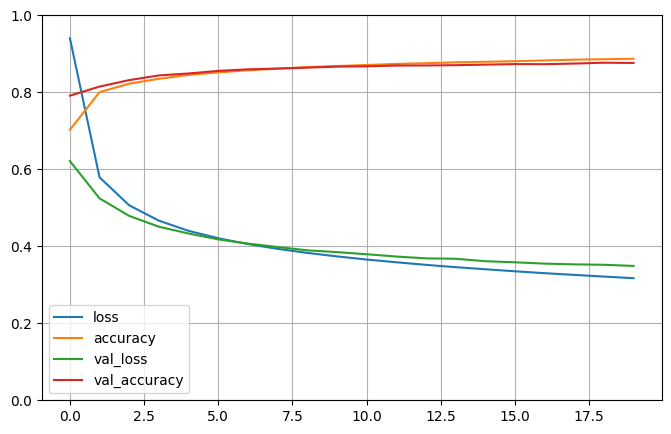

In [37]:
plot_learning_curves(history)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 4 – Use Callbacks

### 4.1)
The `fit()` method accepts a `callbacks` argument. Try training your model with a large number of epochs, a validation set, and with a few callbacks from `keras.callbacks`:
* `TensorBoard`: specify a log directory. It should be a subdirectory of a root logdir, such as `./my_logs/run_1`, and it should be different every time you train your model. You can use a timestamp in the subdirectory's path to ensure that it changes at every run.
* `EarlyStopping`: specify `patience=5`
* `ModelCheckpoint`: specify the path of the checkpoint file to save (e.g., `"my_mnist_model.h5"`) and set `save_best_only=True`

Notice that the `EarlyStopping` callback will interrupt training before it reaches the requested number of epochs. This reduces the risk of overfitting.

In [38]:
root_logdir = os.path.join(os.curdir, "my_logs")

### 4.2)
The Jupyter plugin for tensorboard was loaded at the beginning of this notebook (`%load_ext tensorboard`), so you can now simply start it by using the `%tensorboard` magic command. Explore the various tabs available, in particular the SCALARS tab to view learning curves, the GRAPHS tab to view the computation graph, and the PROFILE tab which is very useful to identify bottlenecks if you run into performance issues.

In [39]:
%tensorboard --logdir {root_logdir}

### 4.3)
The early stopping callback only stopped training after 10 epochs without progress, so your model may already have started to overfit the training set. Fortunately, since the `ModelCheckpoint` callback only saved the best models (on the validation set), the last saved model is the best on the validation set, so try loading it using `keras.models.load_model()`. Finally evaluate it on the test set.

### 4.4)
Look at the list of available callbacks at https://keras.io/callbacks/

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 4 – Solution

### 4.1)
The `fit()` method accepts a `callbacks` argument. Try training your model with a large number of epochs, a validation set, and with a few callbacks from `keras.callbacks`:
* `TensorBoard`: specify a log directory. It should be a subdirectory of a root logdir, such as `./my_logs/run_1`, and it should be different every time you train your model. You can use a timestamp in the subdirectory's path to ensure that it changes at every run.
* `EarlyStopping`: specify `patience=5`
* `ModelCheckpoint`: specify the path of the checkpoint file to save (e.g., `"my_mnist_model.h5"`) and set `save_best_only=True`

Notice that the `EarlyStopping` callback will interrupt training before it reaches the requested number of epochs. This reduces the risk of overfitting.

In [40]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(1e-3), metrics=["accuracy"])

In [41]:
logdir = os.path.join(root_logdir, "run_{}".format(time.time()))

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True),
]
history = model.fit(X_train_scaled, y_train, epochs=50,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=callbacks)

Epoch 1/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.9485 - accuracy: 0.6956 - val_loss: 0.6317 - val_accuracy: 0.7894
Epoch 2/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5797 - accuracy: 0.7997 - val_loss: 0.5273 - val_accuracy: 0.8162
Epoch 3/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5049 - accuracy: 0.8227 - val_loss: 0.4800 - val_accuracy: 0.8336
Epoch 4/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4646 - accuracy: 0.8365 - val_loss: 0.4521 - val_accuracy: 0.8454
Epoch 5/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4380 - accuracy: 0.8446 - val_loss: 0.4330 - val_accuracy: 0.8504
Epoch 6/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4187 - accuracy: 0.8523 - val_loss: 0.4186 - val_accuracy: 0.8560
Epoch 7/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4035 - accuracy: 0.8577 - val_loss: 0.4072 - val_accuracy:

### 4.2)
Done

### 4.3)
The early stopping callback only stopped training after 10 epochs without progress, so your model may already have started to overfit the training set. Fortunately, since the `ModelCheckpoint` callback only saved the best models (on the validation set), the last saved model is the best on the validation set, so try loading it using `keras.models.load_model()`. Finally evaluate it on the test set.

In [42]:
model = keras.models.load_model("my_mnist_model.h5")

In [43]:
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.3239 - accuracy: 0.8902


[0.3239324688911438, 0.8902000188827515]

### 4.4)
Look at the list of available callbacks at https://keras.io/callbacks/

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 5 – A neural net for regression

### 5.1)
Load the California housing dataset using `sklearn.datasets.fetch_california_housing`. This returns an object with a `DESCR` attribute describing the dataset, a `data` attribute with the input features, and a `target` attribute with the labels. The goal is to predict the price of houses in a district (a census block) given some stats about that district. This is a regression task (predicting values).

### 5.2)
Split the dataset into a training set, a validation set and a test set using Scikit-Learn's `sklearn.model_selection.train_test_split()` function.

### 5.3)
Scale the input features (e.g., using a `sklearn.preprocessing.StandardScaler`). Once again, don't forget that you should not fit the validation set or the test set, only the training set.

### 5.4)
Now build, train and evaluate a neural network to tackle this problem. Then use it to make predictions on the test set.

**Tips**:
* Since you are predicting a single value per district (the median house price), there should only be one neuron in the output layer.
* Usually for regression tasks you don't want to use any activation function in the output layer (in some cases you may want to use `"relu"` or `"softplus"` if you want to constrain the predicted values to be positive, or `"sigmoid"` or `"tanh"` if you want to constrain the predicted values to 0-1 or -1-1).
* A good loss function for regression is generally the `"mean_squared_error"` (aka `"mse"`). When there are many outliers in your dataset, you may prefer to use the `"mean_absolute_error"` (aka `"mae"`), which is a bit less precise but less sensitive to outliers.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 5 – Solution

### 5.1)
Load the California housing dataset using `sklearn.datasets.fetch_california_housing`. This returns an object with a `DESCR` attribute describing the dataset, a `data` attribute with the input features, and a `target` attribute with the labels. The goal is to predict the price of houses in a district (a census block) given some stats about that district. This is a regression task (predicting values).

In [44]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [45]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [46]:
housing.data.shape

(20640, 8)

In [47]:
housing.target.shape

(20640,)

### 5.2)
Split the dataset into a training set, a validation set and a test set using Scikit-Learn's `sklearn.model_selection.train_test_split()` function.

In [48]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [49]:
len(X_train), len(X_valid), len(X_test)

(11610, 3870, 5160)

### 5.3)
Scale the input features (e.g., using a `sklearn.preprocessing.StandardScaler`). Once again, don't forget that you should not fit the validation set or the test set, only the training set.

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### 5.4)
Now build, train and evaluate a neural network to tackle this problem. Then use it to make predictions on the test set.

In [51]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3))

In [52]:
callbacks = [keras.callbacks.EarlyStopping(patience=10)]
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_valid_scaled, y_valid), epochs=100,
                    callbacks=callbacks)

Epoch 1/100
363/363 [==============================] - 1s 3ms/step - loss: 2.3532 - val_loss: 1.1343
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.8028 - val_loss: 0.7080
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6728 - val_loss: 0.7902
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6234 - val_loss: 0.8319
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5903 - val_loss: 0.6352
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5632 - val_loss: 0.6096
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5422 - val_loss: 0.5345
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5246 - val_loss: 0.5178
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5100 - val_loss: 0.4761
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4977 - val_lo

In [53]:
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3621


0.3620971143245697

In [54]:
model.predict(X_test_scaled)

162/162 [==============================] - 0s 1ms/step


array([[0.76246876],
       [1.6848557 ],
       [4.100227  ],
       ...,
       [1.5458736 ],
       [2.3714728 ],
       [3.951613  ]], dtype=float32)

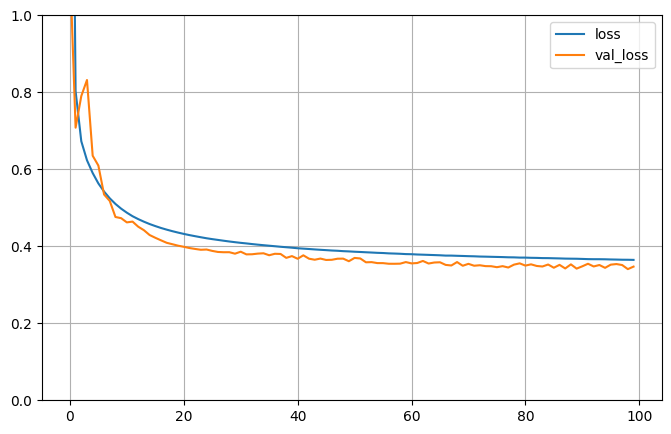

In [55]:
plot_learning_curves(history)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 6 – Hyperparameter search

### 6.1)
Try training your model multiple times, with different a learning rate each time (e.g., 1e-4, 3e-4, 1e-3, 3e-3, 3e-2), and compare the learning curves. For this, you need to create a `keras.optimizers.SGD` optimizer and specify the `learning_rate` in its constructor, then pass this `SGD` instance to the `compile()` method using the `optimizer` argument.

### 6.2)
Let's look at a more sophisticated way to tune hyperparameters. Create a `build_model()` function that takes three arguments, `n_hidden`, `n_neurons`, `learning_rate`, and builds, compiles and returns a model with the given number of hidden layers, the given number of neurons and the given learning rate. It is good practice to give a reasonable default value to each argument.

### 6.3)
Create a `keras.wrappers.scikit_learn.KerasRegressor` and pass the `build_model` function to the constructor. This gives you a Scikit-Learn compatible predictor. Try training it and using it to make predictions. Note that you can pass the `n_epochs`, `callbacks` and `validation_data` to the `fit()` method.

### 6.4)
Use a `sklearn.model_selection.RandomizedSearchCV` to search the hyperparameter space of your `KerasRegressor`.

**Tips**:
* create a `param_distribs` dictionary where each key is the name of a hyperparameter you want to fine-tune (e.g., `"n_hidden"`), and each value is the list of values you want to explore (e.g., `[0, 1, 2, 3]`), or a Scipy distribution from `scipy.stats`.
* You can use the reciprocal distribution for the learning rate (e.g, `reciprocal(3e-3, 3e-2)`).
* Create a `RandomizedSearchCV`, passing the `KerasRegressor` and the `param_distribs` to its constructor, as well as the number of iterations (`n_iter`), and the number of cross-validation folds (`cv`). If you are short on time, you can set `n_iter=10` and `cv=3`. You may also want to set `verbose=2`.
* Finally, call the `RandomizedSearchCV`'s `fit()` method on the training set. Once again you can pass it `n_epochs`, `validation_data` and `callbacks` if you want to.
* The best parameters found will be available in the `best_params_` attribute, the best score will be in `best_score_`, and the best model will be in `best_estimator_`.

### 6.5)
Evaluate the best model found on the test set. You can either use the best estimator's `score()` method, or get its underlying Keras model *via* its `model` attribute, and call this model's `evaluate()` method. Note that the estimator returns the negative mean square error (it's a score, not a loss, so higher is better).

### 6.6)
Finally, save the best Keras model found. **Tip**: it is available via the best estimator's `model` attribute, and just need to call its `save()` method.

**Tip**: while a randomized search is nice and simple, there are more powerful (but complex) options available out there for hyperparameter search, for example:
* [Hyperopt](https://github.com/hyperopt/hyperopt)
* [Hyperas](https://github.com/maxpumperla/hyperas)
* [Sklearn-Deap](https://github.com/rsteca/sklearn-deap)
* [Scikit-Optimize](https://scikit-optimize.github.io/)
* [Spearmint](https://github.com/JasperSnoek/spearmint)
* [PyMC3](https://docs.pymc.io/)
* [GPFlow](https://gpflow.readthedocs.io/)
* [Yelp/MOE](https://github.com/Yelp/MOE)
* Commercial services such as: [Google Cloud ML Engine](https://cloud.google.com/ml-engine/docs/tensorflow/using-hyperparameter-tuning), [Arimo](https://arimo.com/) or [Oscar](http://oscar.calldesk.ai/)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 6 – Solution

### 6.1)
Try training your model multiple times, with different a learning rate each time (e.g., 1e-4, 3e-4, 1e-3, 3e-3, 3e-2), and compare the learning curves. For this, you need to create a `keras.optimizers.SGD` optimizer and specify the `learning_rate` in its constructor, then pass this `SGD` instance to the `compile()` method using the `optimizer` argument.

In [56]:
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
histories = []
for learning_rate in learning_rates:
    model = keras.models.Sequential([
        keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
        keras.layers.Dense(1)
    ])
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    callbacks = [keras.callbacks.EarlyStopping(patience=10)]
    history = model.fit(X_train_scaled, y_train,
                        validation_data=(X_valid_scaled, y_valid), epochs=100,
                        callbacks=callbacks)
    histories.append(history)

Epoch 1/100
363/363 [==============================] - 1s 3ms/step - loss: 4.3061 - val_loss: 16.0641
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 3.2365 - val_loss: 15.2283
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 2.5398 - val_loss: 13.8154
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 2.0635 - val_loss: 12.0994
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 1.7239 - val_loss: 10.4295
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 1.4748 - val_loss: 8.7463
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 1.2864 - val_loss: 7.2060
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 1.1417 - val_loss: 5.8749
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 1.0301 - val_loss: 4.8962
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.9440 - v

Learning rate: 0.0001


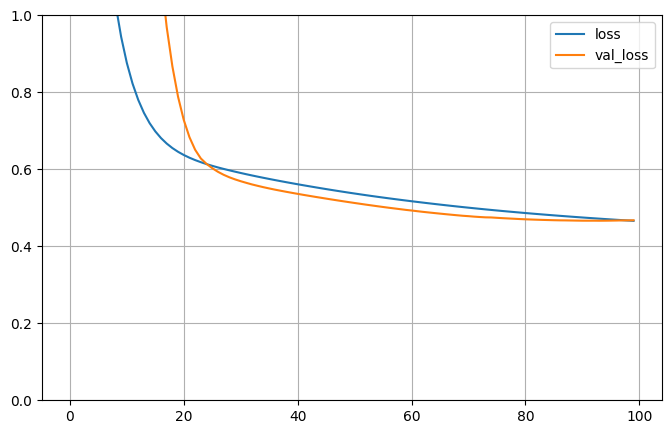

Learning rate: 0.0003


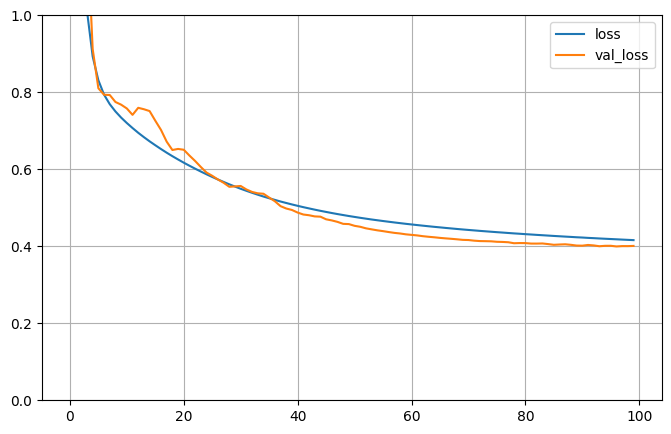

Learning rate: 0.001


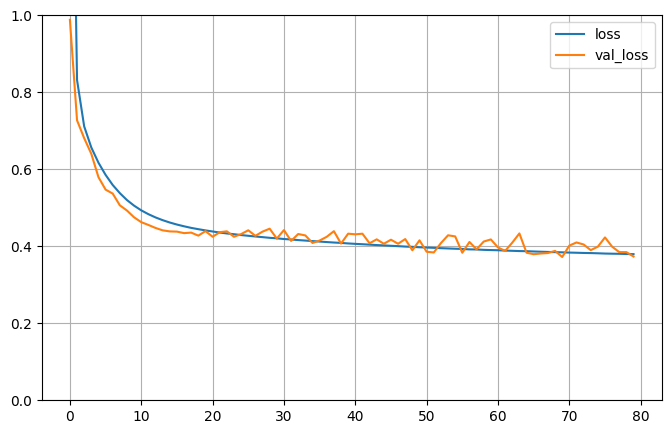

Learning rate: 0.003


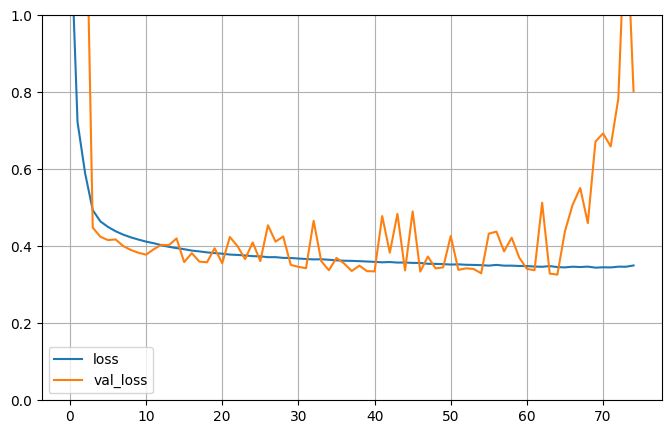

Learning rate: 0.01


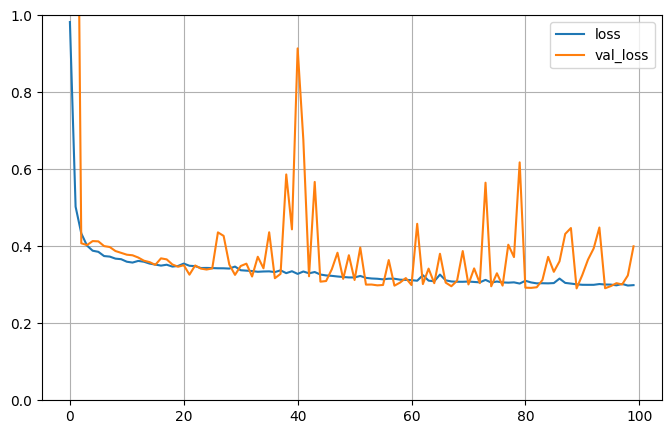

Learning rate: 0.03


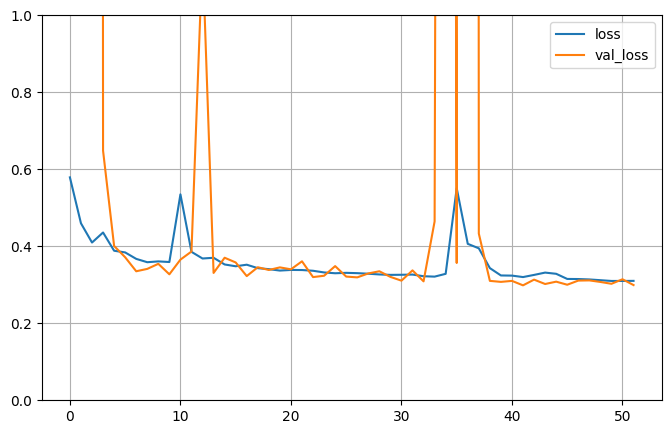

In [57]:
for learning_rate, history in zip(learning_rates, histories):
    print("Learning rate:", learning_rate)
    plot_learning_curves(history)

### 6.2)
Let's look at a more sophisticated way to tune hyperparameters. Create a `build_model()` function that takes three arguments, `n_hidden`, `n_neurons`, `learning_rate`, and builds, compiles and returns a model with the given number of hidden layers, the given number of neurons and the given learning rate. It is good practice to give a reasonable default value to each argument.

In [58]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    options = {"input_shape": X_train.shape[1:]}
    for layer in range(n_hidden + 1):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

### 6.3)
Create a `keras.wrappers.scikit_learn.KerasRegressor` and pass the `build_model` function to the constructor. This gives you a Scikit-Learn compatible predictor. Try training it and using it to make predictions. Note that you can pass the `n_epochs`, `callbacks` and `validation_data` to the `fit()` method.

In [59]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/home/mike/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [60]:
keras_reg.fit(X_train_scaled, y_train, epochs=100,
              validation_data=(X_valid_scaled, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 1s 3ms/step - loss: 1.1772 - val_loss: 1.5242
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5852 - val_loss: 0.5380
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5048 - val_loss: 0.5200
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4584 - val_loss: 0.4235
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4307 - val_loss: 0.8072
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4183 - val_loss: 0.5327
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4047 - val_loss: 0.4130
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3961 - val_loss: 0.3656
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3859 - val_loss: 0.4066
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3816 - val_lo

In [61]:
keras_reg.predict(X_test_scaled)

162/162 [==============================] - 0s 1ms/step


array([0.68055093, 1.5444785 , 4.6468554 , ..., 1.4209397 , 2.359931  ,
       4.095768  ], dtype=float32)

### 6.4)
Use a `sklearn.model_selection.RandomizedSearchCV` to search the hyperparameter space of your `KerasRegressor`.

**Warning**: due to a change in Scikit-Learn, the following code breaks if we don't use `.tolist()` and `.rvs(1000).tolist()`. See [Keras issue #13586](https://github.com/keras-team/keras/issues/13586) for more details.

In [62]:
from scipy.stats import reciprocal

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

In [63]:
from sklearn.model_selection import RandomizedSearchCV

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)

In [64]:
rnd_search_cv.fit(X_train_scaled, y_train, epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 1.5261 - val_loss: 8.2719
Epoch 2/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6637 - val_loss: 0.7262
Epoch 3/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5000 - val_loss: 0.4436
Epoch 4/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4178 - val_loss: 0.3922
Epoch 5/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3885 - val_loss: 0.3760
Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3746 - val_loss: 0.3683
Epoch 7/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3646 - val_loss: 0.3655
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3582 - val_loss: 0.3593
Epoch 9/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3532 - val_loss: 0.3556
Epoch 10/100
242/242 [========

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7ff86a704f90>,
                   param_distributions={'learning_rate': [0.026811340783886965,
                                                          0.0008695907290108833,
                                                          0.004822742839429479,
                                                          0.004682536548504844,
                                                          0.00046926318144453765,
                                                          0.0009100949213767175,
                                                          0.002359496217736406,
                                                          0.0011499707567342423,
                                                          0.022056500747845178,
                                                          0.001229038637240...
                                                          0.00336626110

In [65]:
rnd_search_cv.best_params_

{'n_neurons': 48, 'n_hidden': 2, 'learning_rate': 0.006396691199651379}

In [66]:
rnd_search_cv.best_score_

-0.3183169364929199

In [67]:
rnd_search_cv.best_estimator_

### 6.5)
Evaluate the best model found on the test set. You can either use the best estimator's `score()` method, or get its underlying Keras model *via* its `model` attribute, and call this model's `evaluate()` method. Note that the estimator returns the negative mean square error (it's a score, not a loss, so higher is better).

In [68]:
rnd_search_cv.score(X_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.2808


-0.280759334564209

In [69]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.2808


0.280759334564209

### 6.6)
Finally, save the best Keras model found. **Tip**: it is available via the best estimator's `model` attribute, and just need to call its `save()` method.

In [70]:
model.save("my_fine_tuned_housing_model.h5")

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 7 – The functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer, as shown on the following diagram:

<img src="images/wide_and_deep_net.png" title="Wide and deep net" width=300 />

### 7.1)
Use Keras' functional API to implement a Wide & Deep network to tackle the California housing problem.

**Tips**:
* You need to create a `keras.layers.Input` layer to represent the inputs. Don't forget to specify the input `shape`.
* Create the `Dense` layers, and connect them by using them like functions. For example, `hidden1 = keras.layers.Dense(30, activation="relu")(input)` and `hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)`
* Use the `keras.layers.concatenate()` function to concatenate the input layer and the second hidden layer's output.
* Create a `keras.models.Model` and specify its `inputs` and `outputs` (e.g., `inputs=[input]`).
* Then use this model just like a `Sequential` model: you need to compile it, display its summary, train it, evaluate it and use it to make predictions.

### 7.2)
After the Sequential API and the Functional API, let's try the Subclassing API:
* Create a subclass of the `keras.models.Model` class.
* Create all the layers you need in the constructor (e.g., `self.hidden1 = keras.layers.Dense(...)`).
* Use the layers to process the `input` in the `call()` method, and return the output.
* Note that you do not need to create a `keras.layers.Input` in this case.
* Also note that `self.output` is used by Keras, so you should use another name for the output layer (e.g., `self.output_layer`).

**When should you use the Subclassing API?**
* Both the Sequential API and the Functional API are declarative: you first declare the list of layers you need and how they are connected, and only then can you feed your model with actual data. The models that these APIs build are just static graphs of layers. This has many advantages (easy inspection, debugging, saving, loading, sharing, etc.), and they cover the vast majority of use cases, but if you need to build a very dynamic model (e.g., with loops or conditional branching), or if you want to experiment with new ideas using an imperative programming style, then the Subclassing API is for you. You can pretty much do any computation you want in the `call()` method, possibly with loops and conditions, using Keras layers of even low-level TensorFlow operations.
* However, this extra flexibility comes at the cost of less transparency. Since the model is defined within the `call()` method, Keras cannot fully inspect it. All it sees is the list of model attributes (which include the layers you define in the constructor), so when you display the model summary you just see a list of unconnected layers. Consequently, you cannot save or load the model without writing extra code. So this API is best used only when you really need the extra flexibility.

In [71]:
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        # create layers here

    def call(self, input):
        # write any code here, using layers or even low-level TF code
        return output

model = MyModel()

### 7.3)
Now suppose you want to send only features 0 to 4 directly to the output, and only features 2 to 7 through the hidden layers, as shown on the following diagram. Use the functional API to build, train and evaluate this model.

**Tips**:
* You need to create two `keras.layers.Input` (`input_A` and `input_B`)
* Build the model using the functional API, as above, but when you build the `keras.models.Model`, remember to set `inputs=[input_A, input_B]`
* When calling `fit()`, `evaluate()` and  `predict()`, instead of passing `X_train_scaled`, pass `(X_train_scaled_A, X_train_scaled_B)` (two NumPy arrays containing only the appropriate features copied from `X_train_scaled`).

<img src="images/multiple_inputs.png" title="Multiple inputs" width=300 />

### 7.4)
Build the multi-input and multi-output neural net represented in the following diagram.

<img src="images/multiple_inputs_and_outputs.png" title="Multiple inputs and outputs" width=400 />

**Why?**

There are many use cases in which having multiple outputs can be useful:
* Your task may require multiple outputs, for example, you may want to locate and classify the main object in a picture. This is both a regression task (finding the coordinates of the object's center, as well as its width and height) and a classification task.
* Similarly, you may have multiple independent tasks to perform based on the same data. Sure, you could train one neural network per task, but in many cases you will get better results on all tasks by training a single neural network with one output per task. This is because the neural network can learn features in the data that are useful across tasks.
* Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model's ability to generalize). For example, you may want to add some auxiliary outputs in a neural network architecture (as shown in the diagram) to ensure that that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

**Tips**:
* Building the model is pretty straightforward using the functional API. Just make sure you specify both outputs when creating the `keras.models.Model`, for example `outputs=[output, aux_output]`.
* Each output has its own loss function. In this scenario, they will be identical, so you can either specify `loss="mse"` (this loss will apply to both outputs) or `loss=["mse", "mse"]`, which does the same thing.
* The final loss used to train the whole network is just a weighted sum of all loss functions. In this scenario, you want most to give a much smaller weight to the auxiliary output, so when compiling the model, you must specify `loss_weights=[0.9, 0.1]`.
* When calling `fit()` or `evaluate()`, you need to pass the labels for all outputs. In this scenario the labels will be the same for the main output and for the auxiliary output, so make sure to pass `(y_train, y_train)` instead of `y_train`.
* The `predict()` method will return both the main output and the auxiliary output.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 7 – Solution

### 7.1)
Use Keras' functional API to implement a Wide & Deep network to tackle the California housing problem.

In [72]:
input = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

In [73]:
model = keras.models.Model(inputs=[input], outputs=[output])

In [74]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3))

In [75]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_124 (Dense)              (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_125 (Dense)              (None, 30)           930         ['dense_124[0][0]']              
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_125[0][0]']          

In [76]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 1.8180 - val_loss: 2.1259
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6892 - val_loss: 2.0886
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6358 - val_loss: 0.6093
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6000 - val_loss: 0.7716
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5711 - val_loss: 0.5974
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5471 - val_loss: 0.5168
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5288 - val_loss: 0.6758
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5111 - val_loss: 0.5126
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4984 - val_loss: 0.6410
Epoch 10/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4844 - val_loss: 0.5199

In [77]:
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.4702


0.4702286720275879

In [78]:
model.predict(X_test_scaled)

162/162 [==============================] - 0s 1ms/step


array([[0.7235298],
       [1.4789143],
       [3.0739334],
       ...,
       [1.3035921],
       [2.6871588],
       [3.653856 ]], dtype=float32)

### 7.2)
After the Sequential API and the Functional API, let's try the Subclassing API:
* Create a subclass of the `keras.models.Model` class.
* Create all the layers you need in the constructor (e.g., `self.hidden1 = keras.layers.Dense(...)`).
* Use the layers to process the `input` in the `call()` method, and return the output.
* Note that you do not need to create a `keras.layers.Input` in this case.
* Also note that `self.output` is used by Keras, so you should use another name for the output layer (e.g., `self.output_layer`).

In [79]:
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden1 = keras.layers.Dense(30, activation="relu")
        self.hidden2 = keras.layers.Dense(30, activation="relu")
        self.output_ = keras.layers.Dense(1)

    def call(self, input):
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [80]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(1e-3))

In [81]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 1.6868 - val_loss: 3.6839
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7498 - val_loss: 1.9717
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6703 - val_loss: 1.1313
Epoch 4/10
363/363 [==============================] - 1s 4ms/step - loss: 0.6299 - val_loss: 0.6942
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5929 - val_loss: 0.5607
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5667 - val_loss: 0.6025
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5450 - val_loss: 0.5078
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5266 - val_loss: 0.4896
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5105 - val_loss: 0.4738
Epoch 10/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4969 - val_loss: 0.4676

In [82]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_127 (Dense)           multiple                  270       
                                                                 
 dense_128 (Dense)           multiple                  930       
                                                                 
 dense_129 (Dense)           multiple                  39        
                                                                 
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.4888


0.488766610622406

In [84]:
model.predict(X_test_scaled)

162/162 [==============================] - 0s 1ms/step


array([[0.42204022],
       [1.4024637 ],
       [2.7707279 ],
       ...,
       [1.4241228 ],
       [2.764002  ],
       [3.6900408 ]], dtype=float32)

### 7.3)
Now suppose you want to send only features 0 to 4 directly to the output, and only features 2 to 7 through the hidden layers, as shown on the diagram. Use the functional API to build, train and evaluate this model.

In [85]:
input_A = keras.layers.Input(shape=[5])
input_B = keras.layers.Input(shape=[6])

In [86]:
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)

In [87]:
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [88]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3))

In [89]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 dense_130 (Dense)              (None, 30)           210         ['input_3[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_131 (Dense)              (None, 30)           930         ['dense_130[0][0]']              
                                                                                            

In [90]:
X_train_scaled_A = X_train_scaled[:, :5]
X_train_scaled_B = X_train_scaled[:, 2:]
X_valid_scaled_A = X_valid_scaled[:, :5]
X_valid_scaled_B = X_valid_scaled[:, 2:]
X_test_scaled_A = X_test_scaled[:, :5]
X_test_scaled_B = X_test_scaled[:, 2:]

In [91]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], y_train, epochs=10,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], y_valid))

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 2.0372 - val_loss: 4.7381
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.8592 - val_loss: 1.8443
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6605 - val_loss: 0.7610
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5939 - val_loss: 0.5542
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5545 - val_loss: 0.5174
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5265 - val_loss: 0.5822
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5052 - val_loss: 0.4748
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4891 - val_loss: 0.4568
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4760 - val_loss: 0.4445
Epoch 10/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4659 - val_loss: 0.4506

In [92]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.4632


0.463204562664032

In [93]:
model.predict([X_test_scaled_A, X_test_scaled_B])

162/162 [==============================] - 0s 1ms/step


array([[0.45996225],
       [1.6798    ],
       [3.024572  ],
       ...,
       [1.4443407 ],
       [2.3964112 ],
       [3.6097791 ]], dtype=float32)

### 7.4)
Build the multi-input and multi-output neural net represented in the diagram.

In [94]:
input_A = keras.layers.Input(shape=X_train_scaled_A.shape[1:])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)
aux_output = keras.layers.Dense(1)(hidden2)

In [95]:
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [96]:
model.compile(loss="mean_squared_error", loss_weights=[0.9, 0.1],
              optimizer=keras.optimizers.SGD(1e-3))

In [97]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 dense_133 (Dense)              (None, 30)           210         ['input_5[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_134 (Dense)              (None, 30)           930         ['dense_133[0][0]']              
                                                                                            

In [98]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], [y_train, y_train], epochs=10,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], [y_valid, y_valid]))

Epoch 1/10
363/363 [==============================] - 2s 4ms/step - loss: 2.1002 - dense_135_loss: 1.9108 - dense_136_loss: 3.8047 - val_loss: 1.1000 - val_dense_135_loss: 0.8207 - val_dense_136_loss: 3.6139
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.9165 - dense_135_loss: 0.7421 - dense_136_loss: 2.4863 - val_loss: 1.0399 - val_dense_135_loss: 0.7500 - val_dense_136_loss: 3.6488
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.7841 - dense_135_loss: 0.6591 - dense_136_loss: 1.9093 - val_loss: 0.8977 - val_dense_135_loss: 0.6314 - val_dense_136_loss: 3.2938
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.7188 - dense_135_loss: 0.6157 - dense_136_loss: 1.6468 - val_loss: 0.8443 - val_dense_135_loss: 0.6088 - val_dense_136_loss: 2.9636
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6787 - dense_135_loss: 0.5859 - dense_136_loss: 1.5142 - val_loss: 0.7607 - val_dense_135_lo

In [99]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], [y_test, y_test])

162/162 [==============================] - 0s 2ms/step - loss: 0.5684 - dense_135_loss: 0.4924 - dense_136_loss: 1.2522


[0.5683507919311523, 0.49236610531806946, 1.252212643623352]

In [100]:
y_pred, y_pred_aux = model.predict([X_test_scaled_A, X_test_scaled_B])

162/162 [==============================] - 0s 1ms/step


In [101]:
y_pred

array([[0.21534798],
       [1.4276149 ],
       [2.7811403 ],
       ...,
       [1.3483224 ],
       [2.650928  ],
       [3.471211  ]], dtype=float32)

In [102]:
y_pred_aux

array([[0.88845813],
       [1.5761654 ],
       [2.283506  ],
       ...,
       [1.699662  ],
       [2.1365006 ],
       [2.1616051 ]], dtype=float32)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 8 – Deep Nets

Let's go back to Fashion MNIST and build deep nets to tackle it. We need to load it, split it and scale it.

In [103]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [104]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

### 8.1)
Build a sequential model with 20 hidden dense layers, with 100 neurons each, using the ReLU activation function, plus the output layer (10 neurons, softmax activation function). Try to train it for 10 epochs on Fashion MNIST and plot the learning curves. Notice that progress is very slow.

### 8.2)
Update the model to add a `BatchNormalization` layer after every hidden layer. Notice that performance progresses much faster per epoch, although computations are much more intensive. Display the model summary and notice all the non-trainable parameters (the scale $\gamma$ and offset $\beta$ parameters).

### 8.3)
Try moving the BN layers before the hidden layers' activation functions. Does this affect the model's performance?

### 8.4)
Remove all the BN layers, and just use the SELU activation function instead (always use SELU with LeCun Normal weight initialization). Notice that you get better performance than with BN but training is much faster. Isn't it marvelous? :-)

### 8.5)
Try training for 10 additional epochs, and notice that the model starts overfitting. Try adding a Dropout layer (with a 50% dropout rate) just before the output layer. Does it reduce overfitting? What about the final validation accuracy?

**Warning**: you should not use regular Dropout, as it breaks the self-normalizing property of the SELU activation function. Instead, use AlphaDropout, which is designed to work with SELU.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 8 – Solution

### 8.1)
Build a sequential model with 20 hidden dense layers, with 100 neurons each, using the ReLU activation function, plus the output layer (10 neurons, softmax activation function). Try to train it for 10 epochs on Fashion MNIST and plot the learning curves. Notice that progress is very slow.

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 2.3018 - accuracy: 0.1580 - val_loss: 2.3011 - val_accuracy: 0.1932
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.3003 - accuracy: 0.2001 - val_loss: 2.2994 - val_accuracy: 0.2004
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 2.2980 - accuracy: 0.2290 - val_loss: 2.2965 - val_accuracy: 0.2354
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.2940 - accuracy: 0.2292 - val_loss: 2.2911 - val_accuracy: 0.2446
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.2864 - accuracy: 0.2338 - val_loss: 2.2808 - val_accuracy: 0.2302
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.2702 - accuracy: 0.2184 - val_loss: 2.2564 - val_accuracy: 0.2078
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.2281 - accuracy: 0.2038 - val_loss: 2.1882 - val_accuracy:

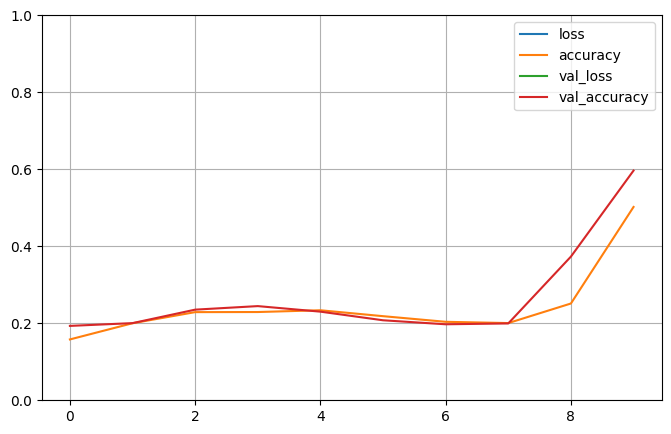

In [105]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.2)
Update the model to add a `BatchNormalization` layer after every hidden layer. Notice that performance progresses much faster per epoch, although computations are much more intensive. Display the model summary and notice all the non-trainable parameters (the scale $\gamma$ and offset $\beta$ parameters).

Epoch 1/10
1719/1719 [==============================] - 25s 12ms/step - loss: 1.9537 - accuracy: 0.3489 - val_loss: 1.0100 - val_accuracy: 0.6452
Epoch 2/10
1719/1719 [==============================] - 20s 11ms/step - loss: 1.0767 - accuracy: 0.6223 - val_loss: 0.7562 - val_accuracy: 0.7246
Epoch 3/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.9298 - accuracy: 0.6715 - val_loss: 0.6740 - val_accuracy: 0.7538
Epoch 4/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.8605 - accuracy: 0.6916 - val_loss: 0.6338 - val_accuracy: 0.7656
Epoch 5/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.8037 - accuracy: 0.7089 - val_loss: 0.5962 - val_accuracy: 0.7796
Epoch 6/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.7672 - accuracy: 0.7226 - val_loss: 0.5685 - val_accuracy: 0.7894
Epoch 7/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.7420 - accuracy: 0.7335 - val_loss: 0.5500 -

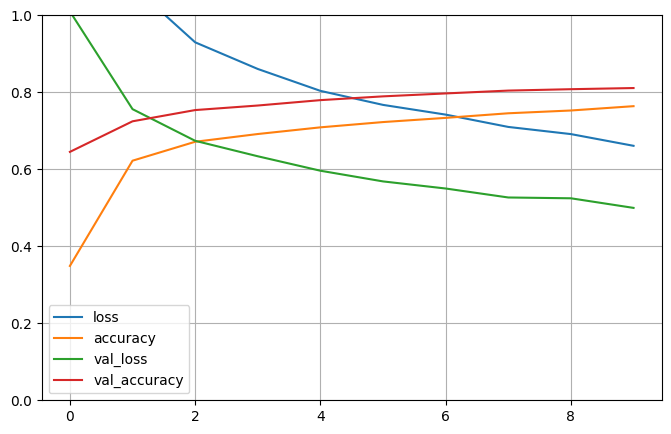

In [106]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

In [107]:
model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_158 (Dense)           (None, 100)               78500     
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dense_159 (Dense)           (None, 100)               10100     
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_160 (Dense)           (None, 100)             

### 8.3)
Try moving the BN layers before the hidden layers' activation functions. Does this affect the model's performance?

Epoch 1/10
1719/1719 [==============================] - 24s 12ms/step - loss: 2.0057 - accuracy: 0.2942 - val_loss: 1.3370 - val_accuracy: 0.5612
Epoch 2/10
1719/1719 [==============================] - 20s 12ms/step - loss: 1.2213 - accuracy: 0.5917 - val_loss: 0.8364 - val_accuracy: 0.7152
Epoch 3/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.9833 - accuracy: 0.6669 - val_loss: 0.7146 - val_accuracy: 0.7516
Epoch 4/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.8782 - accuracy: 0.7007 - val_loss: 0.6348 - val_accuracy: 0.7750
Epoch 5/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.8084 - accuracy: 0.7252 - val_loss: 0.6000 - val_accuracy: 0.7876
Epoch 6/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.7669 - accuracy: 0.7395 - val_loss: 0.5702 - val_accuracy: 0.7980
Epoch 7/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.7291 - accuracy: 0.7514 - val_loss: 0.5402 -

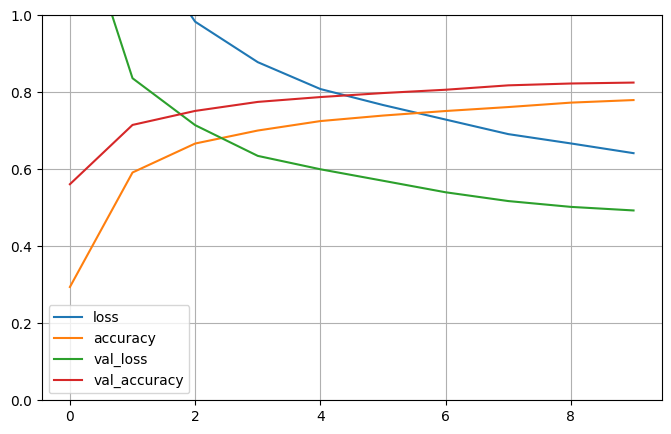

In [108]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.4)
Remove all the BN layers, and just use the SELU activation function instead (always use SELU with LeCun Normal weight initialization). Notice that you get better performance than with BN but training is much faster. Isn't it marvelous? :-)

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6713 - accuracy: 0.7651 - val_loss: 0.5111 - val_accuracy: 0.8164
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4586 - accuracy: 0.8358 - val_loss: 0.4519 - val_accuracy: 0.8370
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4074 - accuracy: 0.8531 - val_loss: 0.4177 - val_accuracy: 0.8508
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3764 - accuracy: 0.8636 - val_loss: 0.4031 - val_accuracy: 0.8544
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3534 - accuracy: 0.8719 - val_loss: 0.3879 - val_accuracy: 0.8596
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3364 - accuracy: 0.8776 - val_loss: 0.3961 - val_accuracy: 0.8588
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3210 - accuracy: 0.8831 - val_loss: 0.3835 - val_accuracy:

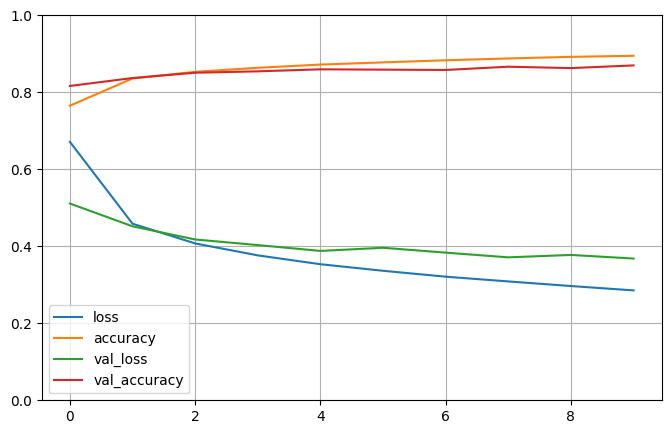

In [109]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.5)
Try training for 10 additional epochs, and notice that the model starts overfitting. Try adding a Dropout layer (with a 50% dropout rate) just before the output layer. Does it reduce overfitting? What about the final validation accuracy?

Epoch 1/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2768 - accuracy: 0.8994 - val_loss: 0.3632 - val_accuracy: 0.8668
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2668 - accuracy: 0.9031 - val_loss: 0.3658 - val_accuracy: 0.8668
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2593 - accuracy: 0.9061 - val_loss: 0.3633 - val_accuracy: 0.8692
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2511 - accuracy: 0.9093 - val_loss: 0.3588 - val_accuracy: 0.8698
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2431 - accuracy: 0.9116 - val_loss: 0.3676 - val_accuracy: 0.8680
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2367 - accuracy: 0.9131 - val_loss: 0.3659 - val_accuracy: 0.8712
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2282 - accuracy: 0.9176 - val_loss: 0.3574 - val_accuracy:

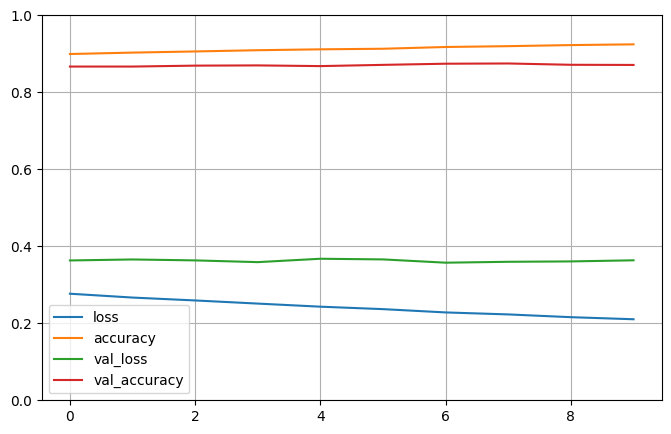

In [110]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

Epoch 1/20
1719/1719 [==============================] - 9s 5ms/step - loss: 1.1477 - accuracy: 0.6168 - val_loss: 0.7585 - val_accuracy: 0.8094
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6641 - accuracy: 0.7835 - val_loss: 0.6802 - val_accuracy: 0.8356
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5532 - accuracy: 0.8202 - val_loss: 0.6377 - val_accuracy: 0.8482
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4973 - accuracy: 0.8381 - val_loss: 0.6253 - val_accuracy: 0.8570
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4559 - accuracy: 0.8522 - val_loss: 0.5964 - val_accuracy: 0.8596
Epoch 6/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4273 - accuracy: 0.8591 - val_loss: 0.6075 - val_accuracy: 0.8618
Epoch 7/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4051 - accuracy: 0.8653 - val_loss: 0.5865 - val_accuracy:

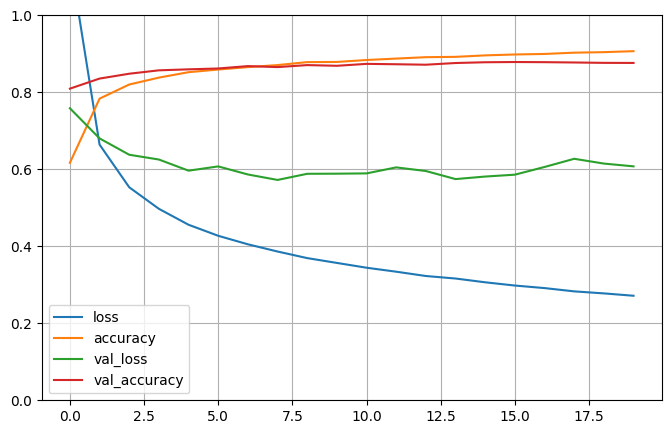

In [111]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.AlphaDropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)